# Лабораторная работа #1
$\textbf{Градиентный спуск.}$

Рассмотрим задачу оптимизации

$\min \left\{(x - \mu_0)^\top A (x - \mu_0) : \|x\|_2^2 \leq 1 \right\}$,

где $x \in \mathbb{R}^n$, $A$ - симметричная, положительно определенная матрица, $\mu_0 = \left(1, 1, \ldots, 1\right)^\top \in \mathbb{R}^n$.

## Пункт 1. Исследование задачи на выпуклость 

Обозначим $f(x) = (x - \mu_0)^\top A (x - \mu_0)$.

$\textbf{Анализ целевой функции}$

Функция $f(x)$ представляет собой квадратичную форму. Мы знаем, что функция $x^\top Ax$ выпукла, если матрица $A$ положительно полуопрделена. Поскольку $A$ в данном случае положительно определенная, $x^\top Ax$ выпукла. Квадратичная форма $(x - \mu_0)^\top A (x - \mu_0)$ является просто сдвигом $x^\top Ax$ на вектор $\mu_0$, что не влияет на выпуклость. Таким образом, $f(x)$ выпукла.

$\textbf{Анализ ограничения}$

Ограничение задается условием: $\|x\|_2^2 \leq 1$. Это означает, что $x$ должен находиться внутри или на границе единичного шара в $\mathbb{R}^n$. Единичный шар является выпуклым множеством, так как норма $\|x\|_2$ - выпуклая функция.

Поскольку и целевая функция $f(x)$, и ограничение $\|x\|_2^2 \leq 1$ выпуклы, вся задача оптимизации является выпуклой. 

## Пункт 2. Поиск глобального минимума с помощью CVX

Упростиим функцию $f(x)$, чтобы найти ее градиент. 

$f(x) = (x - \mu_0)^\top A (x - \mu_0) = $

$(x^\top - \mu_0^\top)(Ax - A\mu_0) = $

$x^\top Ax - \underbrace{x^\top A\mu_0 - \mu_0^\top Ax}_{\text{равны из симметричности }A} + \mu_0^\top A\mu_0 = $

$x^\top Ax - 2\mu_0^\top Ax + \mu_0^\top A\mu_0$

Теперь дифференцируем $f(x)$.

$f(x)[\partial] = \partial\left(x^\top Ax - 2\mu_0^\top Ax + \underbrace{\mu_0^\top A\mu_0}_{\text{константа}}\right) = $

$\partial\left(x^\top Ax\right) - \partial\left(2\mu_0^\top Ax\right) = $

$\partial x^\top Ax + x^\top A\partial x - 2\mu_0^\top A\partial x = $

$\underbrace{Ax + x^\top A}_{\text{равны из симметричности }A} - \underbrace{2\mu_0^\top A}_{\text{то же, что и } 2A\mu_0} = $

$2Ax - 2A\mu_0 = 2A(x - \mu_0)$

Итак, для нашей задачии градиент целевой функции будет равен $ \nabla f(x) = 2A\left(x - \mu_0\right). $

Также для проверки условия оптимальности понадобится градиент ограничения. Частная производная $\sum_{i=1}^n x_i^2$ по переменной $x_j$ (компоненте вектора $x$) равна:

$\frac{\partial}{\partial x_j} (\sum_{i=1}^n x_i^2) = \frac{\partial}{\partial x_j} (x_1^2 + x_2^2 + \ldots + x_n^2) = 2x_j$.

Таким образом, градиент функции $g(x)$ составит:

$ \nabla g(x) = \left[2x_1, 2x_2, \ldots, 2x_n\right] = 2x $.

In [1]:
import cvxpy as cp
import numpy as np

def objective_function(x, mu_0, A):
    """Objective function
       f(x) = (x - mu_0)^T A (x - mu_0)
    """
    return (x - mu_0).T @ A @ (x - mu_0)

def gradient_objective(x, mu_0, A):
    """Gradient
       f'(x) = 2 A (x - mu_0)
    """
    return 2 * A @ (x - mu_0)

def gradient_constraint(x):
    """Gradient
       g'(x) = 2 x
    """
    return 2 * x

def project_to_unit_ball(x):
    """Projects a vector onto the unit ball.
    """
    norm = np.linalg.norm(x, 2)
    if norm > 1:
        return x / norm
    return x

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def solve_cvx(A, mu_0, x_0=None):
    """Solves the convex optimization problem and returns 
       the optimal solution and its optimality.
    """
    assert np.allclose(A, A.T), "Matrix A must be symmetric"
    assert is_pos_def(A), "Matrix A must be positive semi-definite"
    assert A.shape[0] == mu_0.shape[0], "Matrix A and vector mu_0 must be the same size"
    
    x = cp.Variable(n)
    if x_0 is not None:
        x.value = x_0
        
    # Wrapping A as a positive semi-definite matrix
    A_wrapped = cp.psd_wrap(A)

    objective = cp.Minimize(cp.quad_form(x - mu_0, A_wrapped))
    constraints = [cp.sum_squares(x) <= 1]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, eps=1e-9)

    x_star = x.value
    optimal_value = problem.value
    
    optimality = np.linalg.norm(project_to_unit_ball(gradient_objective(x_star, mu_0, A)) + 
                                project_to_unit_ball(gradient_constraint(x_star))) < 1e-4 and \
    np.linalg.norm(x_star.astype(np.float32), 2) <= 1
        
    return x_star, optimal_value, optimality


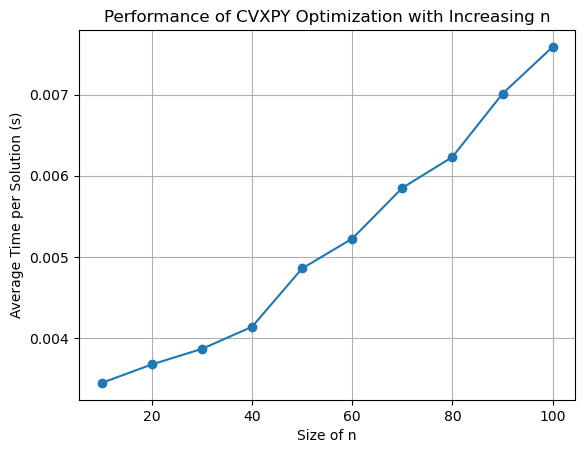

In [2]:
from time import perf_counter

import matplotlib.pyplot as plt

np.random.seed(35)

NREPETITION = 100

sizes = []
times = []
for n in range(10, 101, 10):
    A = np.random.randn(n, n)
    A = A.T @ A
    mu_0 = np.ones(n)
    
    t = 0
    results = []
    for _ in range(NREPETITION):
        x_0 = project_to_unit_ball(np.random.randn(n))
        t -= perf_counter()
        _, _, optimality = solve_cvx(A, mu_0, x_0)
        t += perf_counter()
        results.append(optimality)
    
    assert (np.array(results).all()), "The solution must be optimal"
    times.append(t / NREPETITION)
    sizes.append(n)

plt.plot(sizes, times, marker='o')
plt.xlabel('Size of n')
plt.ylabel('Average Time per Solution (s)')
plt.title('Performance of CVXPY Optimization with Increasing n')
plt.grid(True)
plt.show()

## Пункт 3. Метод градиентного спуска с использованием Backtracking line search
(Section 9.2, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)

In [3]:
def backtracking_line_search(x, delta_x, alpha: float = 0.1, beta: float = 0.3, t: float = 1) -> float:
    """Backtracking Line Search
    """
    it = 1
    while objective_function(x + t * delta_x, mu_0, A) > objective_function(x, mu_0, A) + alpha * t * gradient_objective(x, mu_0, A).T @ delta_x:
        t *= beta
        it += 1
    return t, it

def projected_gradient_descent(A, mu_0, x_0, x_star, epsilon=0.01, max_iterations=100, exit_max_iter=False):
    """Gradient descent
    """
    assert np.allclose(A, A.T), "Matrix A must be symmetric"
    assert is_pos_def(A), "Matrix A must be positive semi-definite"
    assert A.shape[0] == mu_0.shape[0], "Matrix A and vector mu_0 must be the same size"
    
    x = x_0
    convergence = []
    bls_iterations = []
    
    for iteration in range(max_iterations):
        grad = gradient_objective(x, mu_0, A)
        delta_x = -grad
        
        
        _x, it = backtracking_line_search(x, delta_x)
        bls_iterations.append(it)
        
        x_new = x - _x * grad
        x_new = project_to_unit_ball(x_new)
        
        norm = np.linalg.norm(x_star - x_new)
        convergence.append(norm)
        if not exit_max_iter and norm < epsilon:
            return x_new, iteration, convergence, bls_iterations
        
        x = x_new
    
    return x, iteration, convergence, bls_iterations


## Пункт 4. Принцип работы метода, его преимущества и недостатки

Метод обратного поиска (backtracking line search) — это адаптивная процедура для выбора шага в методе градиентного спуска. Этот метод помогает определить оптимальную длину шага, которая обеспечивает достаточное уменьшение значения целевой функции, учитывая предварительные вычисления градиента.

**Принцип работы метода:**

1. *Начальная длина шага:* Изначально задается максимальная длина шага $ t = 1 $, и вычисляется направление спуска $ \Delta x $.

2. *Проверка условия:* Проверяется условие, которое должно подтвердить, что целевая функция $ f $ уменьшается при шаге $ t $. Условие выражается как:

   $f(x + t \Delta x) \leq f(x) + \alpha t \nabla f(x)^\top \Delta x$, где $ \alpha \in (0, 0.5) $ определяет приемлемую степень уменьшения функции.

3. *Уменьшение шага:* Если условие не выполняется, значение шага уменьшается путем умножения на параметр $ \beta \in (0, 1) $ — обычно в диапазоне от 0,1 до 0,8.

4. *Повторение:* Процесс продолжается до тех пор, пока условие не будет выполнено, или шаг не станет слишком малым.

**Преимущества метода:**

* *Адаптивность:* Метод находит шаг динамически, обеспечивая оптимальный баланс между уменьшением функции и длиной шага.

* *Эффективность:* Обратный поиск гарантирует, что каждый шаг даст достаточное уменьшение функции, что ускоряет сходимость.

**Недостатки метода:**

* *Чувствительность к параметрам:* Некорректный выбор $\alpha$ и $\beta$ может привести к слишком большим или слишком малым шагам.

## Пункт 5. Результаты работы метода

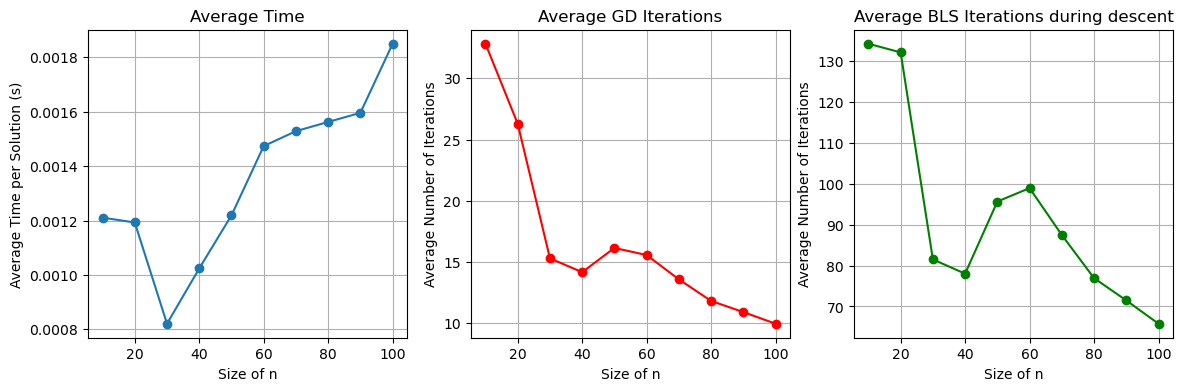

In [4]:
np.random.seed(35)

NREPETITION = 100

sizes = []
times = []
iterations = []
bls_iterations = []
for n in range(10, 101, 10):
    mu_0 = np.ones(n)
    
    t = 0
    iters = 0
    bls_iters = 0
    for _ in range(NREPETITION):
        A = np.random.randn(n, n)
        A = A.T @ A
        x_0 = project_to_unit_ball(np.random.randn(n))
        x_star, _, optimality = solve_cvx(A, mu_0, x_0)
        assert optimality, "The solution must be optimal"
        t -= perf_counter()
        _, it, _, bls_it = projected_gradient_descent(A, mu_0, x_0, x_star, epsilon=1e-9)
        t += perf_counter()
        iters += it
        bls_iters += sum(bls_it)
    
    sizes.append(n)
    times.append(t / NREPETITION)
    iterations.append(iters / NREPETITION)
    bls_iterations.append(bls_iters / NREPETITION)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(sizes, times, marker='o')
ax1.set_xlabel('Size of n')
ax1.set_ylabel('Average Time per Solution (s)')
ax1.set_title('Average Time')
ax1.grid(True)

ax2.plot(sizes, iterations, marker='o', color='r')
ax2.set_xlabel('Size of n')
ax2.set_ylabel('Average Number of Iterations')
ax2.set_title('Average GD Iterations')
ax2.grid(True)

ax3.plot(sizes, bls_iterations, marker='o', color='g')
ax3.set_xlabel('Size of n')
ax3.set_ylabel('Average Number of Iterations')
ax3.set_title('Average BLS Iterations during descent')
ax3.grid(True)

plt.show()

С увеличением $n$ среднее время одной итерации градиентного спуска увеличивается. Тем не менее, при росте $n$ требуется меньше шагов градиентного спуска, чтобы сойтись.

### Зависимость точности от числа итераций

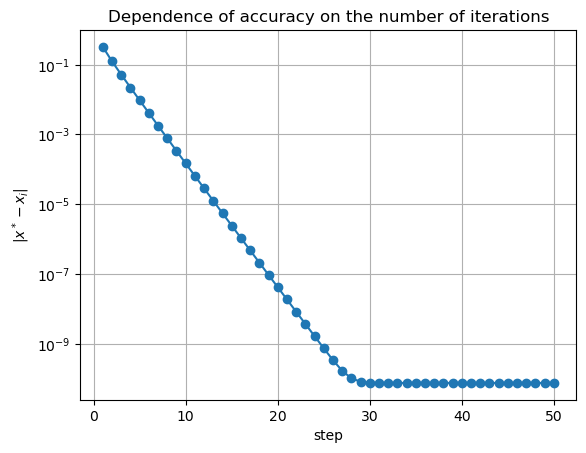

In [5]:
np.random.seed(35)

NREPETITION = 100
MAX_ITER = 50

n = 10

A = np.random.randn(n, n)
A = A.T @ A
mu_0 = np.ones(n)

convergence = []
for _ in range(NREPETITION):
    x_0 = project_to_unit_ball(np.random.randn(n))
    x_star, _, optimality = solve_cvx(A, mu_0, x_0)
    assert optimality, "The solution must be optimal"
    _, _, conv, _ = projected_gradient_descent(A, mu_0, x_0, x_star, epsilon=1e-9, max_iterations=MAX_ITER, exit_max_iter=True)
    convergence.append(conv)
    
convergence = np.array(convergence).mean(axis=0)
plt.plot(np.arange(1, MAX_ITER + 1), convergence, marker='o')
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$|x^* - x_i|$')
plt.title('Dependence of accuracy on the number of iterations')
plt.grid(True)
plt.show()

Чем больше шагов соверашет метод, тем сильнее $x_i$ приближается к $x^*$.

### Зависимость сходимости от отношения максимального и минимального собственного числа A

Сгенерируем матрицу $A$ с заданными собственными значениями, чтобы контролировать отношение максимального собственного числа к минимальному.

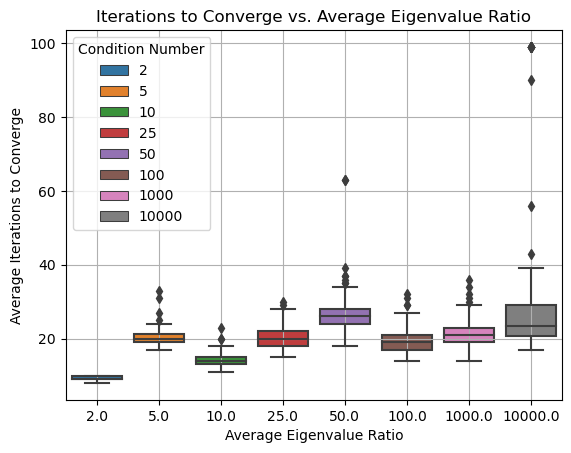

In [6]:
import seaborn as sns
import pandas as pd

def generate_matrix(n, cond_number):
    """Generation of a symmetric matrix A with 
       a given conditional number.
    """
    U, _, _ = np.linalg.svd(np.random.randn(n, n))
    d = np.linspace(1, cond_number, n)
    A = U @ np.diag(d) @ U.T
    return A

np.random.seed(35)

NREPETITION = 100

n = 10
mu_0 = np.ones(n)
cond_numbers_convergence = {it: [] for it in [2, 5, 10, 25, 50, 100, 1000, 10000]}

convergence_data = []
for cond_number in cond_numbers_convergence:
    for _ in range(NREPETITION):
        A = generate_matrix(n, cond_number)
        eigvals = np.linalg.eigvals(A)
        eigvals_ratio = max(eigvals) / min(eigvals)
        
        x_0 = np.random.randn(n)
        x_star, _, optimality = solve_cvx(A, mu_0, x_0)
        assert optimality, "The solution must be optimal"
        _, it, _, _ = projected_gradient_descent(A, mu_0, x_0, x_star, epsilon=1e-9)
        convergence_data.append({"Condition Number": cond_number, "Eigenvalue Ratio": np.float16(eigvals_ratio), "Iterations": it})

df = pd.DataFrame(convergence_data)
        
sns.boxplot(
    data=df,
    x='Eigenvalue Ratio',
    y='Iterations',
    hue='Condition Number',
    dodge=False
)

plt.xlabel('Average Eigenvalue Ratio')
plt.ylabel('Average Iterations to Converge')
plt.title('Iterations to Converge vs. Average Eigenvalue Ratio')
plt.legend(title='Condition Number')
plt.grid(True)
plt.show()

Видим, чем больше отношение максимального собственного числа к минимальному, тем больше шагов требуется градиентному спуску, чтобы сойтись. Сходимость градиентного спуска сильно зависит от числа обусловленности задачи (гессиан в точке оптимума плохо обусловлен, то есть отношение максимального и минимального собственных чисел является большим числом). Геометрически это значит, что линии уровня функции вблизи оптимума похожи на очень вытянутые эллипсоиды [[1]](https://education.yandex.ru/handbook/ml/article/optimizaciya-v-ml). Выбор «удачной» начальной точки также влияет на сходимость [[2]](https://arxiv.org/abs/1907.04232v2).